# Packages

In [ ]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import os
%matplotlib inline
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
import glob
from tqdm import tqdm
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from PIL import Image
from collections import Counter
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from base64 import b64encode
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras import models
from keras.callbacks import ModelCheckpoint

# Utils

In [ ]:
def getFramesDataset(video_name):
    # Read the video from specified path
    cap = cv2.VideoCapture("/content/{}.mp4".format(video_name))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f'fps is for {video_name} is {fps}')
    try:
      # creating a folder named data
      if not os.path.exists('data'):
        os.makedirs('data')
    # if not created then raise error
    except OSError:
      print ('Error: Creating directory of data')
    # frame
    currentframe = 0
    while(True):
      # reading from frame
      ret,frame = cap.read()
      if ret:
        # if video is still left continue creating images
        name = './data/{}_frame'.format(video_name) + str(currentframe) + '.jpg'
        # writing the extracted images
        cv2.imwrite(name, frame)
        currentframe += 1
      else:
        break

  # Release all space and windows once done
    print(f'for {video_name} there was {currentframe} frames extracted')
    cap.release()
    cv2.destroyAllWindows()

def GetAndResizeImagesFromFrame(path):
  new_d = 224 
  root = "/content/data" #change location
  for file in os.listdir(path):
    f_img = root +'/'+file
    try:
        img = Image.open(f_img)
        img = img.resize((new_d, new_d))
        img.save(f_img)
    except IOError:
        pass


#images to numpy array
#get target
def getXY(df):
  images = []
  # for loop to read and store frames
  for i in tqdm(range(df.shape[0])):
      # loading the image and keeping the target size as (224,224,3)
      img = image.load_img(df['image'][i], target_size=(224,224,3))
      # converting it to array
      img = image.img_to_array(img)
      # normalizing the pixel value
      img = img/255
      # appending the image to the train_image list
      images.append(img)
      
  # converting the list to numpy array
  X = np.array(images)
  y = df['label_int']
  # shape of the array
  print(f'X shape is {X.shape}')
  print(f'y shape is {y.shape}')
  return X,y

def show_video(video_path):
  mp4 = open(video_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
      <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

# Build a Dataset

In [ ]:
mylist = [f for f in glob.glob("*.mp4")]
mylist=[item.replace(".mp4", "") for item in mylist]
print(mylist)
for video_name in mylist:
  getFramesDataset(video_name)

['video_902_handshake', 'video-kiss_or_hug', 'video_100_archery']
fps is for video_902_handshake is 12.0
for video_902_handshake there was 70 frames extracted
fps is for video-kiss_or_hug is 12.0
for video-kiss_or_hug there was 68 frames extracted
fps is for video_100_archery is 29.97002997002997
for video_100_archery there was 300 frames extracted


In [ ]:
# resize images
path = r"/content/data" #change location
GetAndResizeImagesFromFrame(path)

#store images in dataframe
image_list = []
image_list=list(glob.glob("/content/data/*.jpg")) #change location
# display(image_list)
df=pd.DataFrame(image_list,columns=['image'])
df['class'] = df['image'].apply(lambda x: x.split('_')[-2])
df['label_int'] = pd.Categorical(df['class']).codes
display(df.head())

#save dataframe to csv
df.to_csv('videos_dataset.csv')

image    class  label_int
0    /content/data/video_100_archery_frame0.jpg  archery          0
1  /content/data/video_100_archery_frame263.jpg  archery          0
2  /content/data/video_100_archery_frame282.jpg  archery          0
3  /content/data/video_100_archery_frame232.jpg  archery          0
4   /content/data/video-kiss_or_hug_frame46.jpg      hug          2

# Experiment 1: train/test split data randomly with CNN model

Get Data

In [ ]:
df = pd.read_csv('videos_dataset.csv')
df = df.drop('Unnamed: 0', axis=1)
display(df.head())
print(Counter(df['class']))

image    class  label_int
0    /content/data/video_100_archery_frame0.jpg  archery          0
1  /content/data/video_100_archery_frame263.jpg  archery          0
2  /content/data/video_100_archery_frame282.jpg  archery          0
3  /content/data/video_100_archery_frame232.jpg  archery          0
4   /content/data/video-kiss_or_hug_frame46.jpg      hug          2

Counter({'archery': 300, 'handshake': 70, 'hug': 68})


Data Split

In [ ]:
#get data numpy and target
X,y = getXY(df)

# creating the training and validation set
# used stratify to have same proportion of each class in the train and test set
# still much more data with archery label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)
print('proportion for train set')
print(Counter(y_train))
print('proportion for test set')
print(Counter(y_test))

# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

100%|██████████| 438/438 [00:00<00:00, 778.62it/s]


X shape is (438, 224, 224, 3)
y shape is (438,)
proportion for train set
Counter({0: 240, 1: 56, 2: 54})
proportion for test set
Counter({0: 60, 1: 14, 2: 14})


Model Architecture

VGG16 architecture:
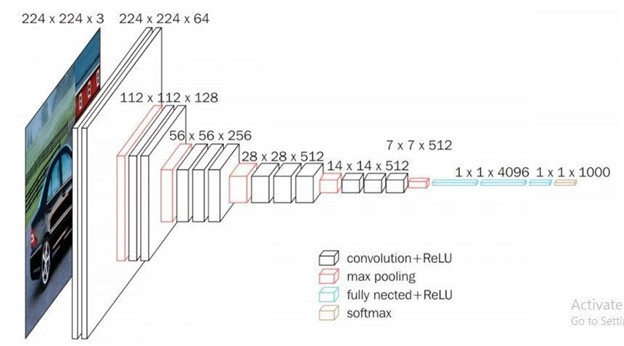

In [ ]:
# creating the base model of pre-trained VGG16 model
# transfer learning so kept the weights but removed the top layers

base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3) )
top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(3, activation='softmax')(top_model)

model = Model(inputs=base_model.input, outputs=top_model)
for layer in base_model.layers:
	layer.trainable = False
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Training

In [ ]:
# defining a function to save the weights of best model

mcp_save = ModelCheckpoint('weights_experiment1_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

# training the model
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=32)

Epoch 1/10
11/11 [==============================] - 3s 251ms/step - loss: 2.0904 - accuracy: 0.7286 - val_loss: 0.0184 - val_accuracy: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 232ms/step - loss: 0.7865 - accuracy: 0.9114 - val_loss: 2.9531e-07 - val_accuracy: 1.0000
Epoch 3/10
11/11 [==============================] - 1s 111ms/step - loss: 0.1811 - accuracy: 0.9571 - val_loss: 1.3438e-06 - val_accuracy: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 219ms/step - loss: 0.0281 - accuracy: 0.9857 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 1s 111ms/step - loss: 0.0356 - accuracy: 0.9943 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 1s 117ms/step - loss: 0.0067 - accuracy: 0.9971 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 1s 111ms/step - loss: 0.0335 - accuracy: 0.9971 - val_loss: 0.0000e+00 - val

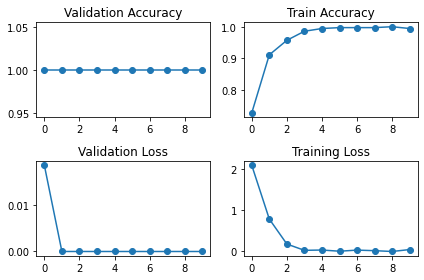

In [ ]:
acc=hist.history["accuracy"]
val_acc=hist.history["val_accuracy"]
loss=hist.history["loss"]
val_loss=hist.history["val_loss"]
epochs=np.arange(0,10)

plt.figure()
plt.subplot(2,2,1)
plt.plot(epochs,val_acc,'-o')
plt.title('Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs,acc,'-o')
plt.title('Train Accuracy')

plt.subplot(2,2,3)
plt.plot(epochs,val_loss,'-o')
plt.title('Validation Loss')

plt.subplot(2,2,4)
plt.plot(epochs,loss,'-o')
plt.title('Training Loss')


plt.tight_layout()

In [ ]:
# loading the trained weights
model.load_weights("weights_experiment1.hdf5")
action_label = {'0':np.array([1.,0.,0.]),'1':np.array([0.,1.,0.]),'2':np.array([0.,0.,1.])}
arr_to_shape = {np.argmax(action_label[x]):x for x in action_label.keys()}
df['prediction']=np.nan
for i in tqdm(range(df.shape[0])):
  # loading the image and keeping the target size as (224,224,3)
  img = image.load_img(df['image'][i], target_size=(224,224,3))
  # converting it to array
  img = image.img_to_array(img)
  # normalizing the pixel value
  img = img/255

  my_img= np.array(img)

  my_prediction = model.predict(my_img.reshape(1,224,224,3))
  (my_prediction)
  df['prediction'][i]=arr_to_shape[np.argmax(my_prediction)]
display(df)

#shows how many correct predictions over 438 predictions
display(Counter(df['label_int'] == df['prediction']))

  0%|          | 0/438 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 438/438 [00:25<00:00, 17.03it/s]


image      class  label_int  \
0       /content/data/video_100_archery_frame0.jpg    archery          0   
1     /content/data/video_100_archery_frame263.jpg    archery          0   
2     /content/data/video_100_archery_frame282.jpg    archery          0   
3     /content/data/video_100_archery_frame232.jpg    archery          0   
4      /content/data/video-kiss_or_hug_frame46.jpg        hug          2   
..                                             ...        ...        ...   
433   /content/data/video_100_archery_frame167.jpg    archery          0   
434   /content/data/video_100_archery_frame272.jpg    archery          0   
435  /content/data/video_902_handshake_frame66.jpg  handshake          1   
436  /content/data/video_902_handshake_frame56.jpg  handshake          1   
437     /content/data/video_100_archery_frame3.jpg    archery          0   

     prediction  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           2.0  
..          ...  
433         0.0  
434         0.0  
435         1.0  
436         1.0  
437         0.0  

[438 rows x 4 columns]

Counter({True: 438})

**OBSERVATIONS**
- Archery label is much more represented than the rest of the labels ==> imbalanced data
- overfitting due to lack of data, model predicts perfectly each frame from the test set
- tried adding/removing dropout but no changes
- tried with different activation function like tanh but no difference

# Experiment 2: Undersampling Archery with CNN model


Get Data

In [ ]:
df2 = pd.read_csv('videos_dataset.csv')
df2 = df2.drop('Unnamed: 0', axis=1)
display(df2.head())
print(Counter(df2['class']))

image    class  label_int
0    /content/data/video_100_archery_frame0.jpg  archery          0
1  /content/data/video_100_archery_frame263.jpg  archery          0
2  /content/data/video_100_archery_frame282.jpg  archery          0
3  /content/data/video_100_archery_frame232.jpg  archery          0
4   /content/data/video-kiss_or_hug_frame46.jpg      hug          2

Counter({'archery': 300, 'handshake': 70, 'hug': 68})


Undersampling

In [ ]:
# get dataframes per label
df_arch = df2[df2['class'] == 'archery']
df_hand = df2[df2['class'] == 'handshake']
df_hug = df2[df2['class'] == 'hug']
df_arch = df_arch.reset_index(drop = True)

# for undersampling, remove randomly 230 samples with archery label
# keep the removed samples to add them to the test set
np.random.seed(10)
remove_n = 230
drop_indices = np.random.choice(df_arch.index, remove_n, replace=False)
df_arch_train =  df_arch.drop(drop_indices)
df_arch_test = df_arch.loc[df_arch.index[drop_indices]]
df_arch_test = df_arch_test.dropna().reset_index(drop = True) #reset index

#get the undersampling dataframe that will be used for training
df_under = pd.concat([df_arch_train, df_hand, df_hug], ignore_index=True)
print('undersampling dataframe info')
display(df_under.info())

undersampling dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      208 non-null    object
 1   class      208 non-null    object
 2   label_int  208 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.0+ KB


None

Data Split

In [ ]:
#images to numpy array
#get target
X, y = getXY(df_under)
X_arch_test, y_arch_test = getXY(df_arch_test)

# creating the training and validation set
# used stratify to have same proportion of each class in the train and test set
# still much more data with archery label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)
X_test = np.concatenate((X_test,X_arch_test))
y_test = np.concatenate((y_test,y_arch_test))
print('proportion for train set')
print(Counter(y_train))
print('proportion for test set')
print(Counter(y_test))

# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

100%|██████████| 208/208 [00:00<00:00, 796.00it/s]


X shape is (208, 224, 224, 3)
y shape is (208,)


100%|██████████| 230/230 [00:00<00:00, 738.42it/s]


X shape is (230, 224, 224, 3)
y shape is (230,)
proportion for train set
Counter({0: 56, 1: 56, 2: 54})
proportion for test set
Counter({0: 244, 2: 14, 1: 14})


Model Architecture

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3) )
top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(3, activation='softmax')(top_model)
model = Model(inputs=base_model.input, outputs=top_model)
for layer in base_model.layers:
	layer.trainable = False
# model.summary()

Training

In [ ]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weights_experiment2.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

# training the model
hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=32)

Epoch 1/10
6/6 [==============================] - 5s 783ms/step - loss: 4.0889 - accuracy: 0.3855 - val_loss: 0.4179 - val_accuracy: 0.9485
Epoch 2/10
6/6 [==============================] - 2s 452ms/step - loss: 5.6752 - accuracy: 0.5181 - val_loss: 1.5798e-04 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 1s 234ms/step - loss: 3.8802 - accuracy: 0.6024 - val_loss: 0.0163 - val_accuracy: 0.9853
Epoch 4/10
6/6 [==============================] - 1s 225ms/step - loss: 2.1894 - accuracy: 0.7530 - val_loss: 9.8454e-04 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 2s 432ms/step - loss: 1.1329 - accuracy: 0.8313 - val_loss: 2.6296e-09 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 2s 404ms/step - loss: 1.2015 - accuracy: 0.8614 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 1s 218ms/step - loss: 0.7402 - accuracy: 0.9096 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


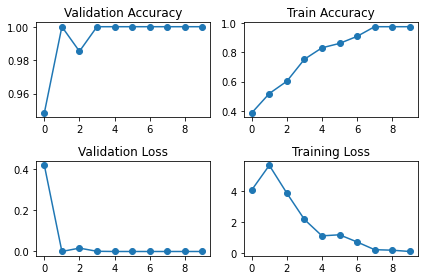

In [ ]:
acc=hist.history["accuracy"]
val_acc=hist.history["val_accuracy"]
loss=hist.history["loss"]
val_loss=hist.history["val_loss"]
epochs=np.arange(0,10)

plt.figure()
plt.subplot(2,2,1)
plt.plot(epochs,val_acc,'-o')
plt.title('Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs,acc,'-o')
plt.title('Train Accuracy')

plt.subplot(2,2,3)
plt.plot(epochs,val_loss,'-o')
plt.title('Validation Loss')

plt.subplot(2,2,4)
plt.plot(epochs,loss,'-o')
plt.title('Training Loss')


plt.tight_layout()

In [ ]:
# loading the trained weights
model.load_weights("weights_experiment2.hdf5")
action_label = {'0':np.array([1.,0.,0.]),'1':np.array([0.,1.,0.]),'2':np.array([0.,0.,1.])}
arr_to_shape = {np.argmax(action_label[x]):x for x in action_label.keys()}
df2['prediction']=np.nan
for i in tqdm(range(df2.shape[0])):
  # loading the image and keeping the target size as (224,224,3)
  img = image.load_img(df2['image'][i], target_size=(224,224,3))
  # converting it to array
  img = image.img_to_array(img)
  # normalizing the pixel value
  img = img/255

  my_img= np.array(img)

  my_prediction = model.predict(my_img.reshape(1,224,224,3))
  (my_prediction)
  df2['prediction'][i]=arr_to_shape[np.argmax(my_prediction)]
display(df2)

#shows how many correct predictions over 438 predictions
display(Counter(df2['label_int'] == df2['prediction']))

  0%|          | 0/438 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 438/438 [00:23<00:00, 18.25it/s]


image      class  label_int  \
0       /content/data/video_100_archery_frame0.jpg    archery          0   
1     /content/data/video_100_archery_frame263.jpg    archery          0   
2     /content/data/video_100_archery_frame282.jpg    archery          0   
3     /content/data/video_100_archery_frame232.jpg    archery          0   
4      /content/data/video-kiss_or_hug_frame46.jpg        hug          2   
..                                             ...        ...        ...   
433   /content/data/video_100_archery_frame167.jpg    archery          0   
434   /content/data/video_100_archery_frame272.jpg    archery          0   
435  /content/data/video_902_handshake_frame66.jpg  handshake          1   
436  /content/data/video_902_handshake_frame56.jpg  handshake          1   
437     /content/data/video_100_archery_frame3.jpg    archery          0   

     prediction  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           2.0  
..          ...  
433         0.0  
434         0.0  
435         1.0  
436         1.0  
437         0.0  

[438 rows x 4 columns]

Counter({True: 438})

**OBSERVATIONS**
- undersampling the category archery did not change the issue due to lack of data
- Played with batch size, epochs and dropout but no difference



```
# This is formatted as code
```

# Experiment 3/4: Data Augmentation with CNN model (train with transform and test on original)

Get Data

In [ ]:
df3 = pd.read_csv('videos_dataset.csv')
df3 = df3.drop('Unnamed: 0', axis=1)
print(Counter(df3['class']))
display(df3.head())

Counter({'archery': 300, 'handshake': 70, 'hug': 68})


image    class  label_int
0    /content/data/video_100_archery_frame0.jpg  archery          0
1  /content/data/video_100_archery_frame263.jpg  archery          0
2  /content/data/video_100_archery_frame282.jpg  archery          0
3  /content/data/video_100_archery_frame232.jpg  archery          0
4   /content/data/video-kiss_or_hug_frame46.jpg      hug          2

Data Augmentation

In [ ]:
trainAug = ImageDataGenerator(rotation_range = 30, zoom_range = 0.15, 
                              width_shift_range = 0.2, height_shift_range = 0.2,
                              shear_range = 0.15, horizontal_flip = True,
                              fill_mode = 'nearest')

testAug = ImageDataGenerator()

100%|██████████| 438/438 [00:00<00:00, 817.80it/s]


X shape is (438, 224, 224, 3)
y shape is (438,)
0


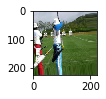

0


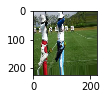

0


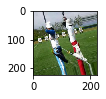

1


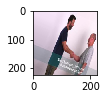

In [ ]:
X,y = getXY(df3)
it = trainAug.flow(X,y, batch_size=32, seed = 26)
it_test = testAug.flow(X,y, batch_size=1, seed = 26)
# generate samples and plot
for i in range(4):
	# define subplot
  plt.subplot(330 + 1 + i)
	# generate batch of images
  batch = it.next()
  print(batch[1][0])
  plt.imshow(batch[0][0], interpolation = 'nearest')
  plt.show()

Model Architecture

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3) )
top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(512, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(128, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(3, activation='softmax')(top_model)
model = Model(inputs=base_model.input, outputs=top_model)
for layer in base_model.layers:
	layer.trainable = False
# model.summary()

Training

In [ ]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weights_experiment4.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# compiling the model
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

# training the model
hist = model.fit_generator(it, epochs = 10, validation_data=it_test, callbacks=[mcp_save])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/10
14/14 [==============================] - 10s 647ms/step - loss: 5.0175 - accuracy: 0.5251 - val_loss: 0.3322 - val_accuracy: 0.8447
Epoch 2/10
14/14 [==============================] - 10s 737ms/step - loss: 3.4142 - accuracy: 0.6279 - val_loss: 0.2428 - val_accuracy: 0.8447
Epoch 3/10
14/14 [==============================] - 13s 958ms/step - loss: 1.6175 - accuracy: 0.7237 - val_loss: 0.2611 - val_accuracy: 0.8447
Epoch 4/10
14/14 [==============================] - 9s 635ms/step - loss: 0.9353 - accuracy: 0.7900 - val_loss: 0.1459 - val_accuracy: 1.0000
Epoch 5/10
14/14 [==============================] - 8s 554ms/step - loss: 0.5578 - accuracy: 0.8151 - val_loss: 0.1607 - val_accuracy: 0.8721
Epoch 6/10
14/14 [==============================] - 9s 632ms/step - loss: 0.5377 - accuracy: 0.8311 - val_loss: 0.1452 - val_accuracy: 0.8516
Epoch 7/10
14/14 [==============================] - 8s 549ms/step - loss: 0.4822 - accuracy: 0.8447 - val_loss: 0.1472 - val_accuracy: 0.9064
Epo

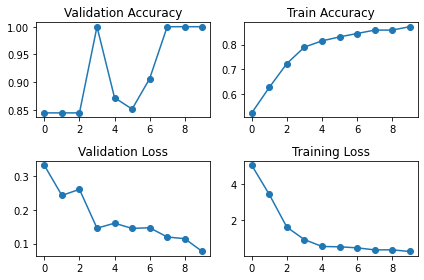

In [ ]:
acc=hist.history["accuracy"]
val_acc=hist.history["val_accuracy"]
loss=hist.history["loss"]
val_loss=hist.history["val_loss"]
epochs=np.arange(0,10)

plt.figure()
plt.subplot(2,2,1)
plt.plot(epochs,val_acc,'-o')
plt.title('Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs,acc,'-o')
plt.title('Train Accuracy')

plt.subplot(2,2,3)
plt.plot(epochs,val_loss,'-o')
plt.title('Validation Loss')

plt.subplot(2,2,4)
plt.plot(epochs,loss,'-o')
plt.title('Training Loss')


plt.tight_layout()

In [ ]:
# loading the trained weights
model.load_weights("weights_experiment4.hdf5")
action_label = {'0':np.array([1.,0.,0.]),'1':np.array([0.,1.,0.]),'2':np.array([0.,0.,1.])}
arr_to_shape = {np.argmax(action_label[x]):x for x in action_label.keys()}
df3['prediction'] = np.nan
df3['likelihood_archery'] = np.nan
df3['likelihood_handshake'] = np.nan
df3['likelihood_hug'] = np.nan
for i in tqdm(range(df3.shape[0])):
  # loading the image and keeping the target size as (224,224,3)
  img = image.load_img(df['image'][i], target_size=(224,224,3))
  # converting it to array
  img = image.img_to_array(img)
  # normalizing the pixel value
  img = img/255

  my_img= np.array(img)

  my_prediction = model.predict(my_img.reshape(1,224,224,3))
  # print(my_prediction[0][0])
  df3['prediction'][i]=arr_to_shape[np.argmax(my_prediction)]
  df3['likelihood_archery'][i] = my_prediction[0][0]
  df3['likelihood_handshake'][i] = my_prediction[0][1]
  df3['likelihood_hug'][i] = my_prediction[0][2]
display(df3)
display(Counter(df3['label_int'] == df3['prediction']))

  0%|          | 0/438 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingW

image      class  label_int  \
0       /content/data/video_100_archery_frame0.jpg    archery          0   
1     /content/data/video_100_archery_frame263.jpg    archery          0   
2     /content/data/video_100_archery_frame282.jpg    archery          0   
3     /content/data/video_100_archery_frame232.jpg    archery          0   
4      /content/data/video-kiss_or_hug_frame46.jpg        hug          2   
..                                             ...        ...        ...   
433   /content/data/video_100_archery_frame167.jpg    archery          0   
434   /content/data/video_100_archery_frame272.jpg    archery          0   
435  /content/data/video_902_handshake_frame66.jpg  handshake          1   
436  /content/data/video_902_handshake_frame56.jpg  handshake          1   
437     /content/data/video_100_archery_frame3.jpg    archery          0   

     prediction  likelihood_archery  likelihood_handshake  likelihood_hug  
0           0.0            1.000000          2.605345e-08    1.214144e-09  
1           0.0            1.000000          1.689496e-09    6.098650e-11  
2           0.0            1.000000          1.461660e-09    5.039447e-11  
3           0.0            1.000000          6.820368e-09    2.995472e-10  
4           2.0            0.014871          1.553727e-01    8.297568e-01  
..          ...                 ...                   ...             ...  
433         0.0            1.000000          1.181175e-08    5.901363e-10  
434         0.0            1.000000          1.081232e-09    3.571956e-11  
435         1.0            0.010699          7.613086e-01    2.279924e-01  
436         1.0            0.010668          7.595741e-01    2.297582e-01  
437         0.0            1.000000          5.328027e-08    2.782710e-09  

[438 rows x 7 columns]

Counter({True: 438})

**OBSERVATIONS**
- Even though we still got a perfect result on test set, data augmentation helped with generalization. 
- Model was trained on the transformed images and predicted the right label on the original images
- Also tried diferrent batch size fro the Image Data Generator but no change


# Video Test With Experiment 3

In [ ]:
# test model experiment on a video 
# returns the label of the video
def getVideoPrediction(video_name):
  video_path = "/content/{}.mp4".format(video_name)
  cap = cv2.VideoCapture(video_path)
  d = []
  current_frame = 0
  while(True):
    # Capture frames in the video
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 250)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 250)
    ret, frame = cap.read()
    current_frame += 1

    if ret:
      name = 'Demo' + '.jpg'
      cv2.imwrite(name, frame)
      Image.open('Demo.jpg').resize((250, 250)).save('Demo.jpg')
      img = image.load_img('Demo.jpg', target_size=(224,224,3))
      img = image.img_to_array(img)
      img = img/255
      my_img= np.array(img)
      model.load_weights("weights_experiment4.hdf5")
      action_label = {'0':np.array([1.,0.,0.]),'1':np.array([0.,1.,0.]),'2':np.array([0.,0.,1.])}
      arr_to_shape = {np.argmax(action_label[x]):x for x in action_label.keys()}
      my_prediction = model.predict(my_img.reshape(1,224,224,3))
      d.append(
          {
              'frame': current_frame,
              'prediction':arr_to_shape[np.argmax(my_prediction)]
          }
      )
    else:
      break

  res = pd.DataFrame(d)
  val = res['prediction'].value_counts().idxmax()
  value_to_label = {'archery':0, 'handshake':1, 'hug':2}
  key_list = list(value_to_label.keys())
  val_list = list(value_to_label.values())
  label = key_list[val_list.index(int(val))]

  
  # release the cap object
  cap.release()
  # close all windows
  cv2.destroyAllWindows() 
  return label

TEST WITH HANDSHAKE

In [ ]:
video_path = "/content/{}.mp4".format('video_902_handshake')
show_video(video_path)

In [ ]:
label = getVideoPrediction('video_902_handshake')
print(f'This video label is {label}')

This video label is handshake


TEST WITH HUG

In [ ]:
video_path = "/content/{}.mp4".format('video-kiss_or_hug')
show_video(video_path)

In [ ]:
label = getVideoPrediction('video-kiss_or_hug')
print(f'This video label is {label}')

This video label is hug


TEST WITH ARCHERY

In [ ]:
video_path = "/content/{}.mp4".format('video_100_archery')
show_video(video_path)

In [ ]:
label = getVideoPrediction('video_100_archery')
print(f'This video label is {label}')

This video label is archery


# Experiment 5: New Model- CNN_LSTM

Get Data

In [ ]:
# lets create folder of data for each video
mylist = ['video_902_handshake', 'video-kiss_or_hug', 'video_100_archery']
for video_name in mylist:
  cap = cv2.VideoCapture("/content/{}.mp4".format(video_name))
  try:
    # creating a folder named data
    if not os.path.exists(video_name):
      os.makedirs(video_name)
  # if not created then raise error
  except OSError:
    print (f'Error: Creating directory of {video_name}')
  # frame
  currentframe = 0
  while(True):
    # reading from frame
    ret,frame = cap.read()
    if ret:
      # if video is still left continue creating images
      name = f'./{video_name}/{video_name}_frame' + str(currentframe) + '.jpg'
      # writing the extracted images
      frame_grey=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      # print(frame_grey.shape)
      cv2.imwrite(name, frame_grey)
      currentframe += 1
    else:
      break

  # Release all space and windows once done
    # print(f'for {video_name} there was {currentframe} frames extracted')
cap.release()
cv2.destroyAllWindows()

Data Split into a fixed continuous list of frames

In [ ]:
# take 10 first frames from each video for training
# display(image_list)
def get10Images(n, mylist): #tried 5 10 20
  frames = []
  for video_name in mylist:
    image_list = []
    image_list_10 = []
    image_list=list(glob.glob(f"/content/{video_name}/*.jpg")) #change location
    for i in range(n*10, n*10 + 10): #now chose 20
      image_list_10.append(image_list[i])
      vid_data = []
    for f in image_list_10:
      img = Image.open(f)
      img = img.resize((250, 250))
  # converting it to array
      img = image.img_to_array(img)
      # print(img.shape)
  # normalizing the pixel value
      img = img/255
      my_img= np.array(img)
      vid_data.append(my_img)
    vid_data=np.array(vid_data)
    frames.append(vid_data)
  return np.array(frames)


train_dataset = get10Images(0, mylist)
train_dataset = train_dataset.reshape((3,10,250,250,1))
train_labels = [1,2,0]
train_labels = np.array(train_labels)

test_dataset = get10Images(1, mylist)
test_dataset = test_dataset.reshape((3,10,250,250,1))
test_labels = [1,2,0]
test_labels = np.array(test_labels)

Model Architecture : CNN - LSTM

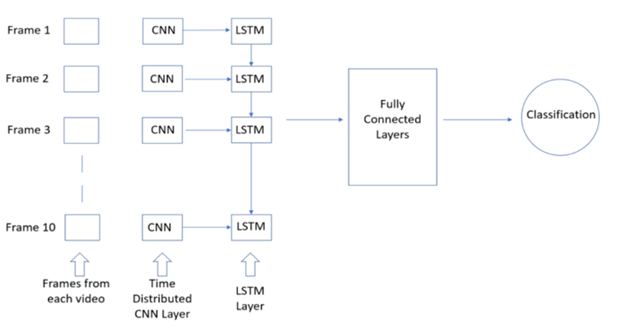

In [ ]:

# model_cnlst = models.Sequential()
# model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu'),input_shape=(20, 250, 250, 1)))
# model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
# model_cnlst.add(TimeDistributed(Conv2D(16, (3, 3), strides=(1,1),activation='relu')))
# model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
# # model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
# # model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
# model_cnlst.add(TimeDistributed(BatchNormalization()))


# model_cnlst.add(TimeDistributed(Flatten()))
# model_cnlst.add(Dropout(0.2))

# model_cnlst.add(LSTM(32,return_sequences=False,dropout=0.2)) # used 32 units

# model_cnlst.add(Dense(64,activation='relu'))
# model_cnlst.add(Dropout(0.2))
# # model_cnlst.add(Dense(32,activation='relu'))
# # model_cnlst.add(Dropout(0.2))
# model_cnlst.add(Dense(3, activation='softmax'))
# model_cnlst.summary()




model_cnlst = models.Sequential()
model_cnlst.add(TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='relu'),input_shape=(10, 250, 250, 1)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(BatchNormalization()))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))

model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(BatchNormalization()))
model_cnlst.add(TimeDistributed(Flatten()))
model_cnlst.add(Dropout(0.2))

model_cnlst.add(LSTM(64,return_sequences=False,dropout=0.2)) # used 32 units
model_cnlst.add(Dense(128,activation='relu'))
model_cnlst.add(BatchNormalization())
model_cnlst.add(Dense(64,activation='relu'))
model_cnlst.add(Dense(32,activation='relu'))
model_cnlst.add(Dropout(0.2))
model_cnlst.add(Dense(3, activation='softmax'))
model_cnlst.summary()




Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_120 (TimeD  (None, 10, 248, 248, 128  1280     
 istributed)                 )                                   
                                                                 
 time_distributed_121 (TimeD  (None, 10, 246, 246, 64)  73792    
 istributed)                                                     
                                                                 
 time_distributed_122 (TimeD  (None, 10, 123, 123, 64)  0        
 istributed)                                                     
                                                                 
 time_distributed_123 (TimeD  (None, 10, 121, 121, 64)  36928    
 istributed)                                                     
                                                                 
 time_distributed_124 (TimeD  (None, 10, 119, 119, 32)

Training

In [ ]:
mcp_save = ModelCheckpoint('weights_experiment5_10.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# compiling the model
model_cnlst.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

# training the model
history = model_cnlst.fit(train_dataset, train_labels, epochs=30, validation_data=(test_dataset, test_labels), callbacks=[mcp_save], batch_size=10)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 1.6845 - accuracy: 0.3333 - val_loss: 1.0971 - val_accuracy: 0.6667
Epoch 2/30
1/1 [==============================] - 0s 249ms/step - loss: 1.4675 - accuracy: 0.3333 - val_loss: 1.1007 - val_accuracy: 0.3333
Epoch 3/30
1/1 [==============================] - 0s 249ms/step - loss: 1.3542 - accuracy: 0.3333 - val_loss: 1.0980 - val_accuracy: 0.3333
Epoch 4/30
1/1 [==============================] - 0s 363ms/step - loss: 0.6948 - accuracy: 0.6667 - val_loss: 1.0961 - val_accuracy: 0.3333
Epoch 5/30
1/1 [==============================] - 0s 251ms/step - loss: 0.3410 - accuracy: 1.0000 - val_loss: 1.0970 - val_accuracy: 0.3333
Epoch 6/30
1/1 [==============================] - 0s 348ms/step - loss: 0.6991 - accuracy: 0.6667 - val_loss: 1.0931 - val_accuracy: 0.3333
Epoch 7/30
1/1 [==============================] - 0s 249ms/step - loss: 0.4675 - accuracy: 0.6667 - val_loss: 1.0938 - val_accuracy: 0.3333
Epoch 8/30
1/1 [=======

In [ ]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=np.arange(0,30)




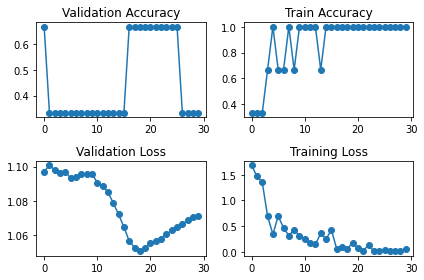

In [ ]:

plt.figure()
plt.subplot(2,2,1)
plt.plot(epochs,val_acc,'-o')
plt.title('Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs,acc,'-o')
plt.title('Train Accuracy')

plt.subplot(2,2,3)
plt.plot(epochs,val_loss,'-o')
plt.title('Validation Loss')

plt.subplot(2,2,4)
plt.plot(epochs,loss,'-o')
plt.title('Training Loss')


plt.tight_layout()



In [ ]:
predictions = model_cnlst.predict(test_dataset)
predictions

array([[0.32144648, 0.33438513, 0.3441684 ],
       [0.32968473, 0.3454695 , 0.32484576],
       [0.3702808 , 0.31333253, 0.31638667]], dtype=float32)

In [ ]:
action_label = {'0':np.array([1.,0.,0.]),'1':np.array([0.,1.,0.]),'2':np.array([0.,0.,1.])}
arr_to_shape = {np.argmax(action_label[x]):x for x in action_label.keys()}
model_cnlst.load_weights("weights_experiment5_10.hdf5")
d = []
video = ['video_100_archery']
for i in range(0, 30):
  test_dataset = get10Images(i, video)
  test_dataset = test_dataset.reshape((1,10,250,250,1))
  predictions = model_cnlst.predict(test_dataset)
  d.append(
      {
          'prediction': arr_to_shape[np.argmax(predictions)]
      }
  )
data_exp5 = pd.DataFrame(d)
display(data_exp5)

d = []
video = ['video_902_handshake']
for i in range(0, 7):
  test_dataset = get10Images(i, video)
  test_dataset = test_dataset.reshape((1,10,250,250,1))
  predictions = model_cnlst.predict(test_dataset)
  d.append(
      {
          'prediction': arr_to_shape[np.argmax(predictions)]
      }
  )
data_exp5 = pd.DataFrame(d)
display(data_exp5)


d = []
video = ['video-kiss_or_hug']
for i in range(0, 6):
  test_dataset = get10Images(i, video)
  test_dataset = test_dataset.reshape((1,10,250,250,1))
  predictions = model_cnlst.predict(test_dataset)
  d.append(
      {
          'prediction': arr_to_shape[np.argmax(predictions)]
      }
  )
data_exp5 = pd.DataFrame(d)
display(data_exp5)

prediction
0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
14          0
15          0
16          0
17          0
18          0
19          0
20          0
21          0
22          0
23          0
24          0
25          0
26          0
27          0
28          0
29          0

prediction
0          1
1          1
2          1
3          1
4          1
5          1
6          1

prediction
0          1
1          1
2          1
3          1
4          1
5          1

**Observations**
- Model not working ==> overfitting (high acc on training very low on testing set)
- Only predicting class archery
